In [20]:
import torch
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# seed = 9
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [22]:
# Image dimensions for ResNet18
resized_img_W = 224
resized_img_H = 224

# Define data augmentation transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((resized_img_W, resized_img_H)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
        transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), shear=(-0.1, 0.1), scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    ]),
    'val': transforms.Compose([
        transforms.Resize((resized_img_W, resized_img_H)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}


# Load datasets
train_data = datasets.ImageFolder(root='/vol/bitbucket/wr323/ImageNetVid_Pre_trained_CNN_feature_Spectral/train', transform=data_transforms['train'])
val_data = datasets.ImageFolder(root='/vol/bitbucket/wr323/videos_with_one_category_img_6FPS/val', transform=data_transforms['val'])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers = 4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True, num_workers = 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train data examples


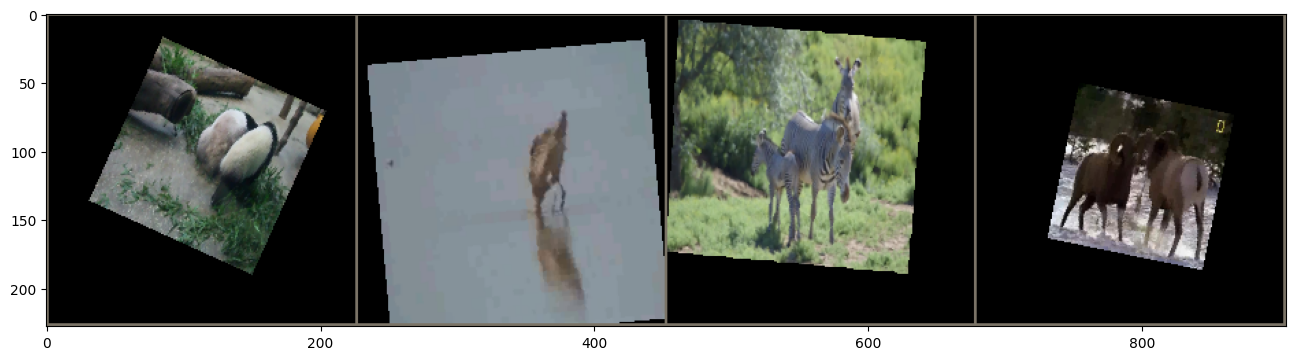

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation data examples


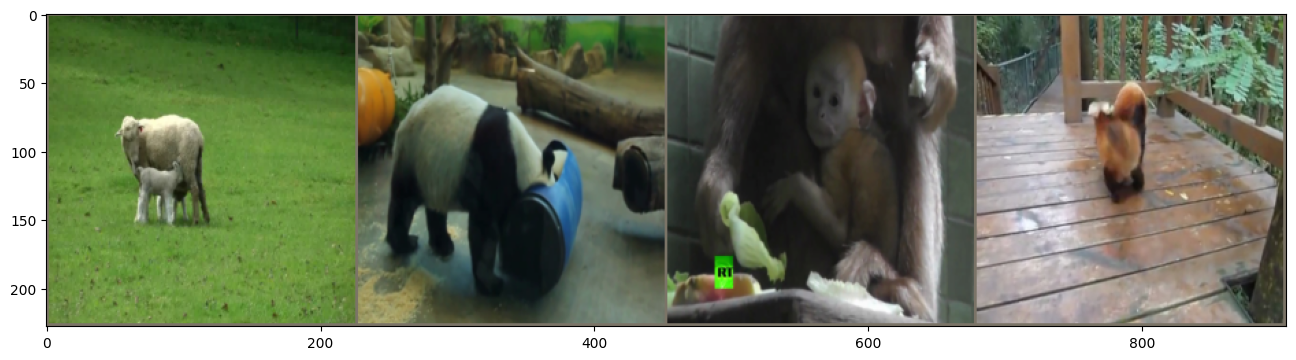

In [23]:

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Function to show an image with specific mean and standard deviation
def imshow(img):
    """Imshow for Tensor."""
    img = img * std[..., None, None] + mean[..., None, None] # Unnormalize using your specific values
    npimg = img.numpy()
    plt.figure(figsize=(16, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
print('Train data examples')
imshow(utils.make_grid(images[:4]))


# Repeat for validation data
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Show images

print('Validation data examples')
imshow(utils.make_grid(images[:4]))



In [24]:
def evaluate(model, val_loader, device, epoch=0):    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not calculate gradients to save memory
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        val_loader = iter(val_loader)
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = correct / total
        f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Epoch {epoch + 1}, Validataion data, Accuracy: {accuracy*100:.2f}%, F1 score : {f1*100:.2f}%')

In [25]:
# Load pre-trained ResNet18
model = resnet18(weights=ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Check if CUDA is available and if so, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)
model = model.to(device)  # Move model to GPU if available

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    last_epoch_loss = float("inf")
    model.train()

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU if available

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update running loss
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Train Loss: {running_loss/len(train_loader)}")

    if epoch >= 4 and last_epoch_loss < 1.1 * running_loss/len(train_loader):
        print("Early stop")
        break
    else:
        last_epoch_loss = running_loss/len(train_loader)

    evaluate(model, val_loader, device, epoch)

print('Finished Training')


device:  cuda:0


Epoch 1: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]

Epoch 1, Train Loss: 2.0561999853919533


Epoch 1, Validataion data, Accuracy: 45.58%, F1 score : 45.22%


Epoch 2: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]

Epoch 2, Train Loss: 1.162918830619139


Epoch 2, Validataion data, Accuracy: 55.56%, F1 score : 57.61%


Epoch 3: 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

Epoch 3, Train Loss: 0.6695578326197231


Epoch 3, Validataion data, Accuracy: 62.41%, F1 score : 62.89%


Epoch 4: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]

Epoch 4, Train Loss: 0.40309402171303244


Epoch 4, Validataion data, Accuracy: 61.72%, F1 score : 62.64%


Epoch 5: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]

Epoch 5, Train Loss: 0.2681867918547462


Epoch 5, Validataion data, Accuracy: 62.64%, F1 score : 61.75%


Epoch 6: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]

Epoch 6, Train Loss: 0.19365050512201645


Epoch 6, Validataion data, Accuracy: 66.42%, F1 score : 66.02%


Epoch 7: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]

Epoch 7, Train Loss: 0.13711418518248727


Epoch 7, Validataion data, Accuracy: 67.80%, F1 score : 67.09%


Epoch 8: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]

Epoch 8, Train Loss: 0.10660605877637863


Epoch 8, Validataion data, Accuracy: 66.20%, F1 score : 65.37%


Epoch 9: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]

Epoch 9, Train Loss: 0.09774614563759636


Epoch 9, Validataion data, Accuracy: 68.57%, F1 score : 68.60%


Epoch 10: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

Epoch 10, Train Loss: 0.06938355503713384


Epoch 10, Validataion data, Accuracy: 66.65%, F1 score : 66.18%
Finished Training


In [26]:
# After training, calculate accuracy and F1 score on validation data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Do not calculate gradients to save memory
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    val_loader = iter(val_loader)
    # print(len(val_loader.dataset))
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy on validation data: {accuracy*100:.2f}%')
print(f'F1 score on validation data: {f1*100:.2f}%')


Accuracy on validation data: 66.65%
F1 score on validation data: 66.18%
